In [37]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr

import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

import metrics as mt


In [ ]:
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]

log_dir = f'../../../data-addition-dilemma/distance_data'
distances_dir = "/home/tane/YAIB/YAIB/results/distances"

map_race = {'asian': 0, 
            'black': 1,
            'other': 2,
            'white': 3}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

format_metric = {'ACC': 'Test Accuracy',
                 'ACC_TEST': 'Test Accuracy',
                 'AUC_TEST': 'Test AUC',
                 'AUC': 'Test AUC', 
                 'ACC_diff': 'Change in Test Accuracy',
                 'ACC_TEST_diff': 'Change in Test Accuracy',
                 'AUC_TEST_diff': 'Change in Test AUC',
                 'AUC_diff': 'Change in Test AUC', }

In [ ]:
def get_hospital(hid, split='train', max_samples=None, sample_ratio=1, rand_seed=42): 
    file_name =f'{hid}/data.npz'
    hos = np.load(os.path.join(log_dir, file_name), allow_pickle=True)
    x = hos[split].item()['features']
    y = hos[split].item()['labels']
    xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)
    if sample_ratio < 1: 
        rng = np.random.default_rng(rand_seed)
        ind = rng.choice(len(x), size=int(len(x)*sample_ratio), replace=False)
        return x[ind], y[ind], xy[ind]
    elif max_samples is not None: 
        if len(x) > max_samples: 
            rng = np.random.default_rng(rand_seed)
            ind = rng.choice(len(x), size=int(max_samples), replace=False)
            return x[ind], y[ind], xy[ind]
        else: 
            return x, y, xy
    else: 
        return x, y, xy

## data quality heuristics

In [ ]:
def compute_binary_subgroup_score(hospital_ids: list, save_dir: str, num_samples: int=1000):
    '''classify black and white patients from each hospital'''
    
    results_x = np.zeros((len(hospital_ids)))
    results_xy = np.zeros((len(hospital_ids)))

    for i, hid in enumerate(hospital_ids):
        x, _, xy = get_hospital(hid, 'train', max_samples=num_samples)
        
        x_white = np.delete(x[x[:, -1] == 3.0], -1, axis=1)
        x_black = np.delete(x[x[:, -1] == 1.0], -1, axis=1)
        
        xy_white = np.delete(xy[xy[:, -2] == 3.0], -2, axis=1)
        xy_black = np.delete(xy[xy[:, -2] == 1.0], -2, axis=1)

        scaler = StandardScaler()
        logistic = LogisticRegression(max_iter=10000, tol=0.1)
        pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

        X_train = np.concatenate((x_white, x_black), axis=0)
        Y_train = np.concatenate((np.ones(len(x_white)), np.zeros(len(x_black))), axis=0)

        pipe.fit(X_train, Y_train)

        x_val, _, xy_val = get_hospital(hid, 'test')
        
        x_val = x_val[(x_val[:, -1] == 1.0) | (x_val[:, -1] == 3.0)]
        xy_val = xy_val[(xy_val[:, -2] == 1.0) | (xy_val[:, -2] == 3.0)]
        
        y_val = x_val[:, -1]
        y_val = np.where(y_val == 3.0, 1, 0)
        
        x_val = np.delete(x_val, -1, axis=1)
        xy_val = np.delete(xy_val, -2, axis=1)

        y_prob = pipe.predict_proba(x_val)[:, 1]
        results_x[i] = roc_auc_score(y_val, y_prob)

        X_train = np.concatenate((xy_white, xy_black), axis=0)
        Y_train = np.concatenate((np.ones(len(xy_white)), np.zeros(len(xy_black))), axis=0)

        pipe.fit(X_train, Y_train)

        y_prob = pipe.predict_proba(xy_val)[:, 1]
        results_xy[i] = roc_auc_score(y_val, y_prob)

    return results_x, results_xy

In [ ]:
binary_score_x, binary_score_xy = compute_binary_subgroup_score(hospital_ids, "")

In [ ]:
def compute_multiclass_subgroup_score(hospital_ids: list, save_dir: str, num_samples: int=1000):
    '''classify all patients from each hospital for multiclass logistic regression'''

    results_x = np.zeros((len(hospital_ids)))
    results_xy = np.zeros((len(hospital_ids)))

    for i, hid in enumerate(hospital_ids):
        x, _, xy = get_hospital(hid, 'train', max_samples=num_samples)
        
        # No need to filter for 1.0 or 3.0, keep all rows and all classes in the 'pred' column
        # Split into features (X_train) and target (Y_train) using the last column as the label
        X_train = np.delete(x, -1, axis=1)
        Y_train = x[:, -1]  # Multiclass target: 0.0, 1.0, 2.0, 3.0

        xy_train = np.delete(xy, -2, axis=1)
        Y_train_xy = xy[:, -2]  # Multiclass target for xy dataset

        # Create and fit the pipeline
        scaler = StandardScaler()
        logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class='multinomial', solver='lbfgs')
        pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

        # Train on the x set
        pipe.fit(X_train, Y_train)

        # Test the model
        x_val, _, xy_val = get_hospital(hid, 'test')
        
        # No need to filter for specific classes, keep all rows and use the full multiclass label set
        X_val = np.delete(x_val, -1, axis=1)
        Y_val = x_val[:, -1]  # Multiclass true labels for x set

        xy_val_features = np.delete(xy_val, -2, axis=1)
        Y_val_xy = xy_val[:, -2]  # Multiclass true labels for xy set

        # Predict probabilities for all classes
        y_prob_x = pipe.predict_proba(X_val)
        y_pred_x = pipe.predict(X_val)
        results_x[i] = accuracy_score(Y_val, y_pred_x)  # You can use accuracy for multiclass

        # Train on the xy set and evaluate
        pipe.fit(xy_train, Y_train_xy)

        y_prob_xy = pipe.predict_proba(xy_val_features)
        y_pred_xy = pipe.predict(xy_val_features)
        results_xy[i] = accuracy_score(Y_val_xy, y_pred_xy)

    return results_x, results_xy

In [ ]:
multi_score_x, multi_score_xy = compute_multiclass_subgroup_score(hospital_ids, "")

## inter-hospital similarities

In [20]:
def compute_binary_subgroup_score(subgroup=None, hospital_ids=hospital_ids, max_train_samples=None):
    """Classify patients between pairs of hospitals."""

    # If subgroup is not None, filter on race_col_idx then drop it.
    # If subgroup is None, just drop that column (use all rows).
    def prep(arr, race_col_idx):
        if subgroup is not None:
            arr = arr[arr[:, race_col_idx] == map_race[subgroup]]
        return arr
    n = len(hospital_ids)
    results_x = np.zeros((n, n))
    results_xy = np.zeros((n, n))

    print("computing pairwise score distance function")

    for test_i, test_h in enumerate(hospital_ids):
        for i, h in enumerate(hospital_ids):
            if h == test_h:
                continue

            # --- train data ---
            if max_train_samples is None:
                x, _, xy = get_hospital(h, 'train')
                x2, _, xy2 = get_hospital(test_h, 'train')
            else:
                x, _, xy = get_hospital(h, 'train', max_samples=max_train_samples)
                x2, _, xy2 = get_hospital(test_h, 'train', max_samples=max_train_samples)

            x = prep(x, -1)
            x2 = prep(x2, -1)
            xy = prep(xy, -2)
            xy2 = prep(xy2, -2)

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("logistic", LogisticRegression(
                    max_iter=10000, tol=0.1, C=0.1, penalty='l2'
                )),
            ])

            # --- model on x ---
            X_train = np.concatenate((x, x2), axis=0)
            y_train = np.concatenate(
                (np.ones(len(x)), np.zeros(len(x2))), axis=0
            )
            pipe.fit(X_train, y_train)

            x_val, _, _ = get_hospital(h, 'test')
            x_val = prep(x_val, -1)
            results_x[i, test_i] = pipe.predict_proba(x_val)[:, 1].mean()

            # --- model on xy ---
            X_train = np.concatenate((xy, xy2), axis=0)
            y_train = np.concatenate(
                (np.ones(len(xy)), np.zeros(len(xy2))), axis=0
            )
            pipe.fit(X_train, y_train)

            _, _, xy_val = get_hospital(h, 'test')
            xy_val = prep(xy_val, -2)
            results_xy[i, test_i] = pipe.predict_proba(xy_val)[:, 1].mean()

    return results_x, results_xy

In [21]:
def compute_binary_subgroup_score_balanced(subgroup=None, hospital_ids=hospital_ids, max_train_samples=None):
    """Classify patients between pairs of hospitals, using balanced train sets."""

    # If subgroup is not None, filter on race_col_idx then drop it.
    # If subgroup is None, just drop that column (use all rows).
    def prep(arr, race_col_idx):
        if subgroup is not None:
            arr = arr[arr[:, race_col_idx] == map_race[subgroup]]
        return arr

    n = len(hospital_ids)
    results_x = np.zeros((n, n))
    results_xy = np.zeros((n, n))

    print("computing pairwise score distance function (balanced)")

    for test_i, test_h in enumerate(hospital_ids):
        for i, h in enumerate(hospital_ids):
            if h == test_h:
                continue

            # --- train data (optionally limited in size) ---
            if max_train_samples is None:
                x,  _, xy  = get_hospital(h,      'train')
                x2, _, xy2 = get_hospital(test_h, 'train')
            else:
                x,  _, xy  = get_hospital(h,      'train', max_samples=max_train_samples)
                x2, _, xy2 = get_hospital(test_h, 'train', max_samples=max_train_samples)

            # subgroup filtering + drop race column
            x  = prep(x,  -1)
            x2 = prep(x2, -1)
            xy  = prep(xy,  -2)
            xy2 = prep(xy2, -2)

            # --- balance: same number of rows from each hospital ---
            min_samples = min(len(x), len(x2))
            x  = x[:min_samples]
            x2 = x2[:min_samples]
            xy  = xy[:min_samples]
            xy2 = xy2[:min_samples]

            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("logistic", LogisticRegression(
                    max_iter=10000, tol=0.1, C=0.1, penalty='l2'
                )),
            ])

            # --- model on x ---
            X_train = np.concatenate((x, x2), axis=0)
            y_train = np.concatenate(
                (np.ones(len(x)), np.zeros(len(x2))), axis=0
            )
            pipe.fit(X_train, y_train)

            x_val, _, _ = get_hospital(h, 'test')
            x_val = prep(x_val, -1)
            results_x[i, test_i] = pipe.predict_proba(x_val)[:, 1].mean()

            # --- model on xy ---
            X_train = np.concatenate((xy, xy2), axis=0)
            y_train = np.concatenate(
                (np.ones(len(xy)), np.zeros(len(xy2))), axis=0
            )
            pipe.fit(X_train, y_train)

            _, _, xy_val = get_hospital(h, 'test')
            xy_val = prep(xy_val, -2)
            results_xy[i, test_i] = pipe.predict_proba(xy_val)[:, 1].mean()

    return results_x, results_xy

In [42]:
# def plot_subgroup_score_heatmaps(plot_mat_x, plot_mat_xy, subgroup):
#     fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)
    
#     vmin = np.sort(np.unique(plot_mat_x))[1]
            
#     sns.heatmap(plot_mat_x, annot=True, cmap="rocket_r", ax=axes[0], 
#                 xticklabels=hospital_ids, 
#             yticklabels=hospital_ids, vmin=vmin)
#     axes[0].set_xlabel("Test Hospital")
#     axes[0].set_ylabel("Added Hospital")
#     axes[0].set_title("Scores_X")

#     vmin = np.sort(np.unique(plot_mat_xy))[1]

#     sns.heatmap(plot_mat_xy, annot=True, cmap="rocket_r", ax=axes[1], 
#                 xticklabels=hospital_ids, 
#             yticklabels=hospital_ids, vmin=vmin)
#     axes[1].set_xlabel("Test Hospital")
#     axes[1].set_ylabel("Added Hospital")
#     axes[1].set_title("Scores_XY")

#     plt.suptitle(f"{subgroup} Similarity Score across hospitals")

def plot_subgroup_score_heatmaps(
    plot_mat_x,
    plot_mat_xy,
    subgroup,
    vmax_x=None,
    vmax_xy=None,
):
    """
    Plot heatmaps for X and XY scores.
    
    - Annotations are shown with 2 decimal places.
    - You can cap the color bar with vmax_x / vmax_xy.
      If None, the true max of the matrix is used.
    """
    fig, axes = plt.subplots(figsize=(15, 7), nrows=1, ncols=2)

    # ----- X heatmap -----
    # ignore NaNs when computing vmin
    valid_x = plot_mat_x[~np.isnan(plot_mat_x)]
    if len(np.unique(valid_x)) > 1:
        vmin_x = np.sort(np.unique(valid_x))[1]
    else:
        vmin_x = np.min(valid_x)

    if vmax_x is None:
        vmax_x = np.nanmax(plot_mat_x)

    sns.heatmap(
        plot_mat_x,
        annot=True,
        fmt=".2f",  
        cmap="rocket_r",
        ax=axes[0],
        xticklabels=hospital_ids,
        yticklabels=hospital_ids,
        vmin=vmin_x,
        vmax=vmax_x,     
    )
    axes[0].set_xlabel("Test Hospital")
    axes[0].set_ylabel("Added Hospital")
    axes[0].set_title("Scores_X")

    # ----- XY heatmap -----
    valid_xy = plot_mat_xy[~np.isnan(plot_mat_xy)]
    if len(np.unique(valid_xy)) > 1:
        vmin_xy = np.sort(np.unique(valid_xy))[1]
    else:
        vmin_xy = np.min(valid_xy)

    if vmax_xy is None:
        vmax_xy = np.nanmax(plot_mat_xy)

    sns.heatmap(
        plot_mat_xy,
        annot=True,
        fmt=".2f",   
        cmap="rocket_r",
        ax=axes[1],
        xticklabels=hospital_ids,
        yticklabels=hospital_ids,
        vmin=vmin_xy,
        vmax=vmax_xy,      
    )
    axes[1].set_xlabel("Test Hospital")
    axes[1].set_ylabel("Added Hospital")
    axes[1].set_title("Scores_XY")

    plt.suptitle(f"{subgroup} Similarity Score across hospitals")
    plt.tight_layout()


computing pairwise score distance function


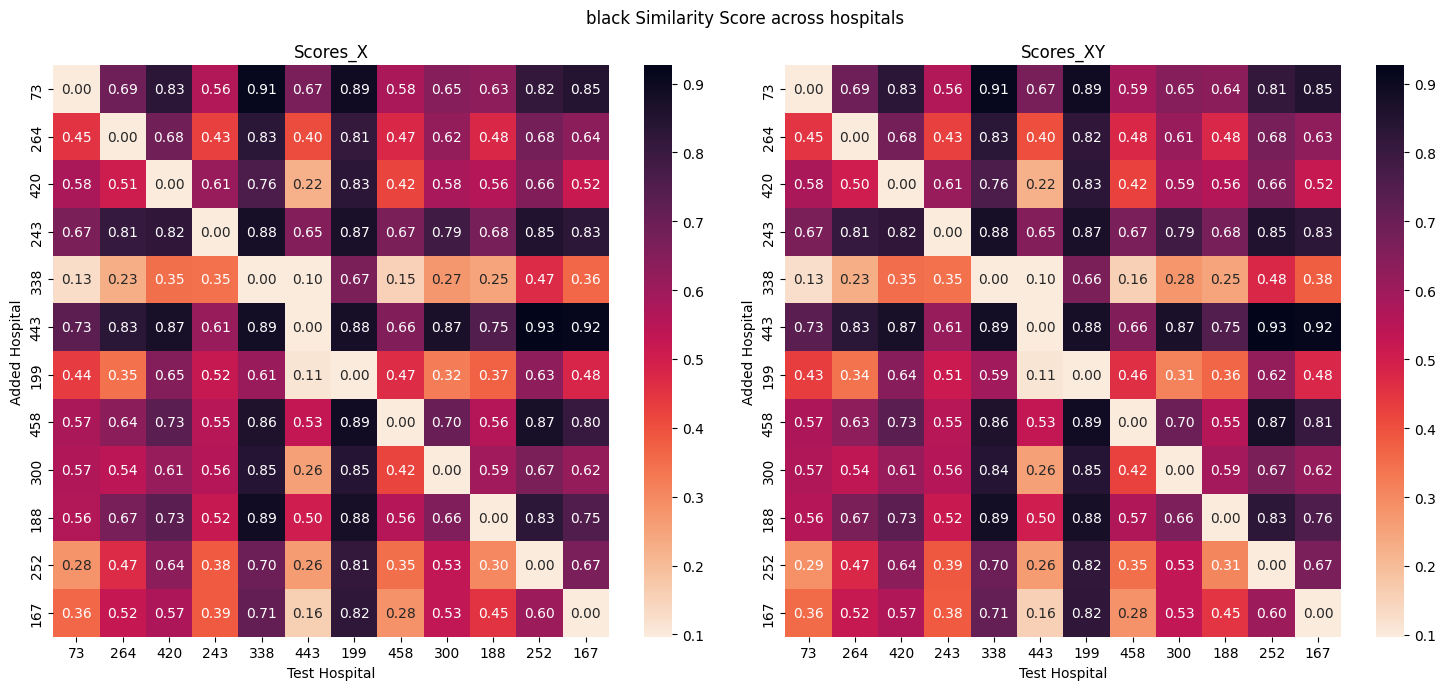

In [43]:
subgroup = "black"
results_x, results_xy = compute_binary_subgroup_score(subgroup)

plot_subgroup_score_heatmaps(results_x, results_xy, subgroup)

computing pairwise score distance function (balanced)


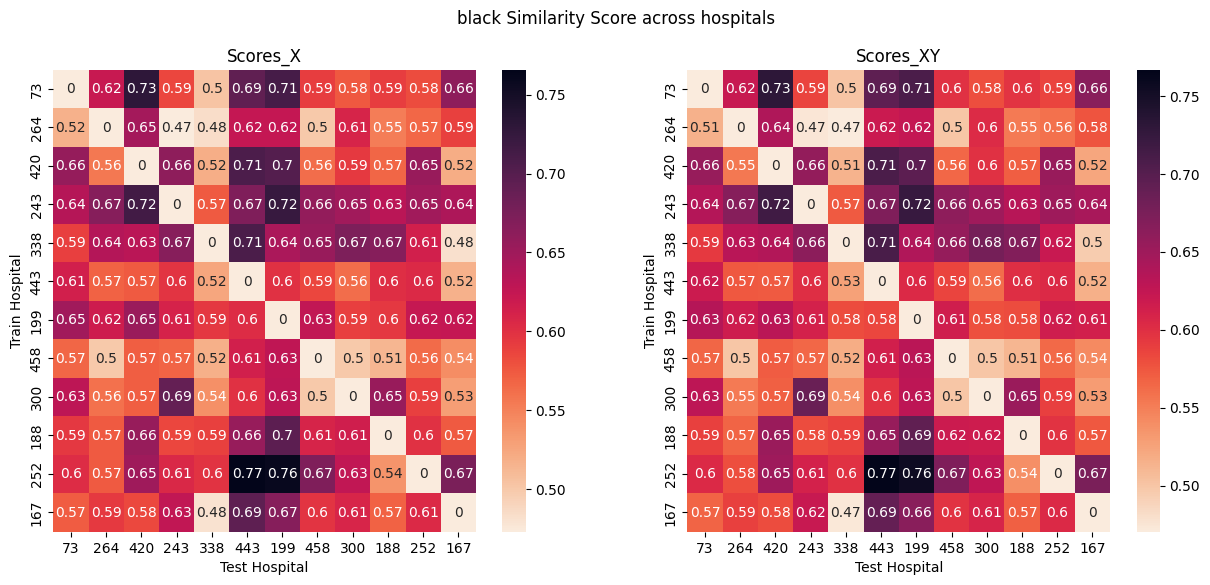

In [23]:
subgroup = "black"
black_results_x_balanced, black_results_xy_balanced = compute_binary_subgroup_score_balanced(subgroup)

plot_subgroup_score_heatmaps(black_results_x_balanced, black_results_xy_balanced, subgroup)

computing pairwise score distance function


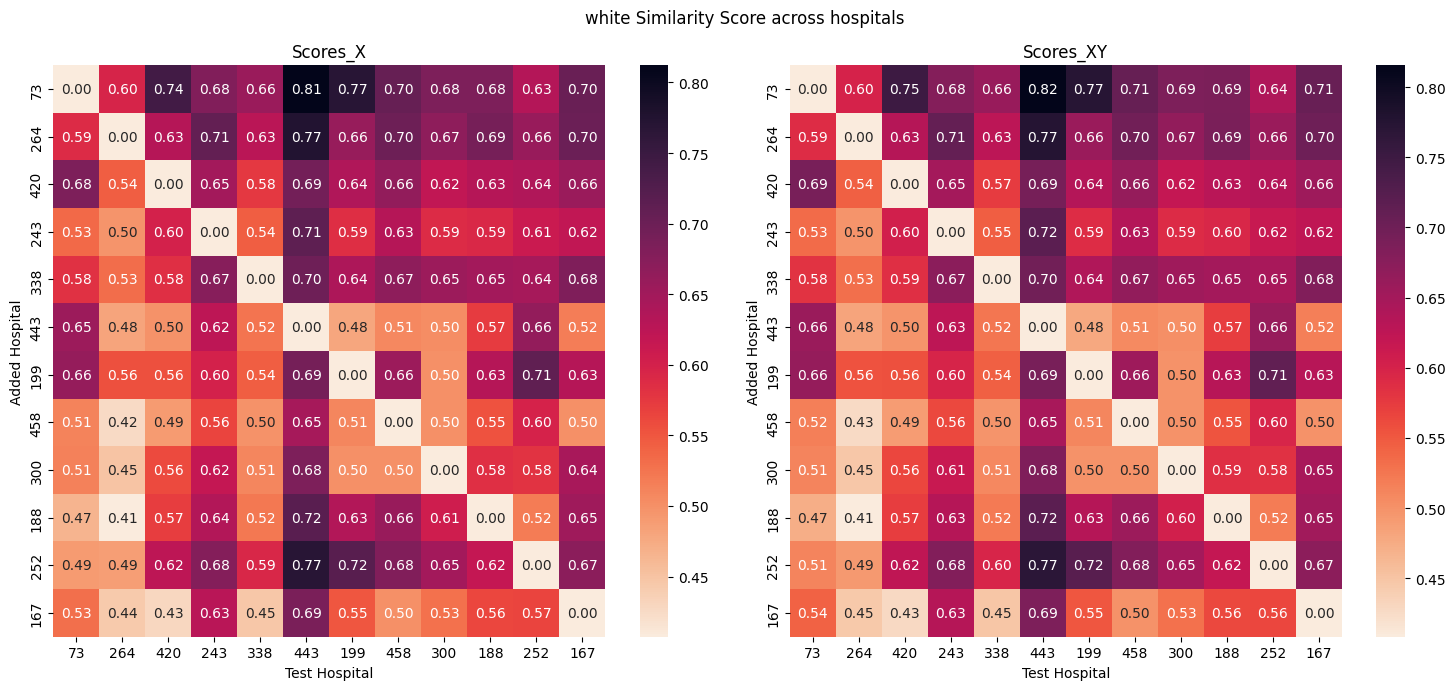

In [44]:
subgroup = "white"
results_x, results_xy = compute_binary_subgroup_score(subgroup)

plot_subgroup_score_heatmaps(results_x, results_xy, subgroup)

computing pairwise score distance function (balanced)


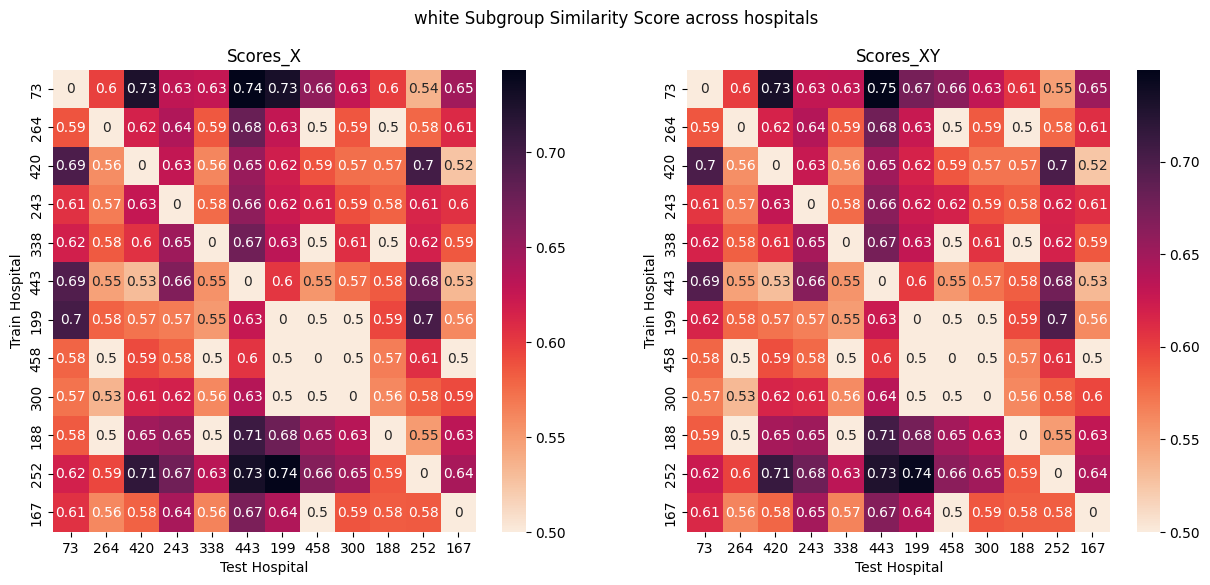

In [13]:
subgroup = "white"
white_results_x_balanced, white_results_xy_balanced = compute_binary_subgroup_score_balanced(subgroup)

plot_subgroup_score_heatmaps(white_results_x_balanced, white_results_xy_balanced, subgroup)

computing pairwise score distance function


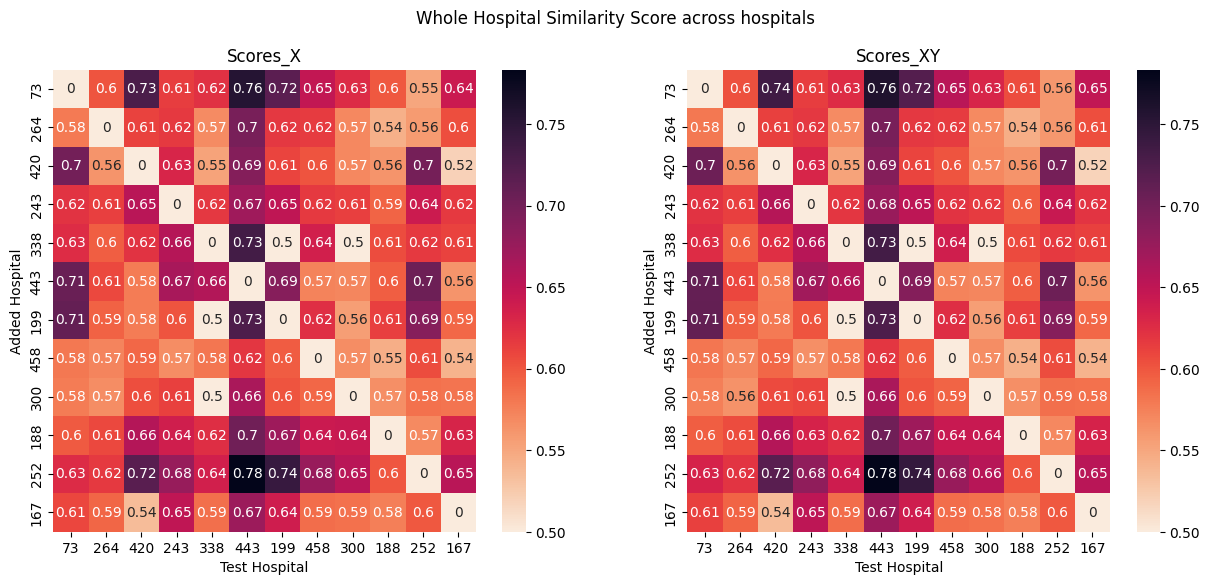

In [29]:
results_x, results_xy = compute_binary_subgroup_score(max_train_samples=1500)

plot_subgroup_score_heatmaps(results_x, results_xy, "Whole Hospital")

computing pairwise score distance function (balanced)


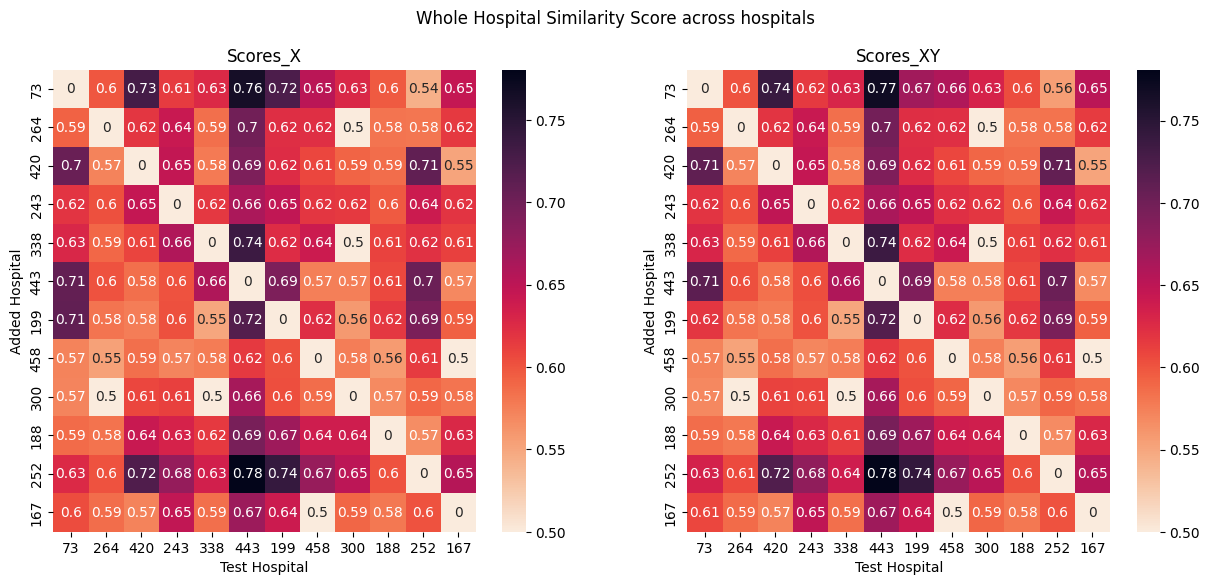

In [30]:
other_results_x_balanced, other_results_xy_balanced = compute_binary_subgroup_score_balanced()

plot_subgroup_score_heatmaps(other_results_x_balanced, other_results_xy_balanced, "Whole Hospital")

### kl divergence

In [38]:
def compute_kl_subgroup_score(subgroup=None, hospital_ids=hospital_ids, max_train_samples=None):
    """
    Compute KL density divergence between all ordered pairs of hospitals.

    For each pair (h, test_h):
        results_x[i, test_i]  = KL_x(h || test_h)  based on x features
        results_xy[i, test_i] = KL_xy(h || test_h) based on xy (features + label)

    Uses folktables_exp.metrics density utilities.
    """

    # If subgroup is not None, filter on race_col_idx but KEEP race as a feature.
    def prep(arr, race_col_idx):
        if subgroup is not None:
            arr = arr[arr[:, race_col_idx] == map_race[subgroup]]
        return arr

    n = len(hospital_ids)
    results_x = np.zeros((n, n))
    results_xy = np.zeros((n, n))

    print("computing pairwise KL density distance function")

    for test_i, test_h in enumerate(hospital_ids):
        for i, h in enumerate(hospital_ids):
            if h == test_h:
                continue

            # --- load (train) data for both hospitals ---
            if max_train_samples is None:
                x,  _, xy  = get_hospital(h,      'train')
                x2, _, xy2 = get_hospital(test_h, 'train')
            else:
                x,  _, xy  = get_hospital(h,      'train', max_samples=max_train_samples)
                x2, _, xy2 = get_hospital(test_h, 'train', max_samples=max_train_samples)

            # subgroup filtering (race kept as feature)
            # x:  race in last column
            # xy: race in second-to-last column, label in last column
            x  = prep(x,  -1)
            x2 = prep(x2, -1)
            xy  = prep(xy,  -2)
            xy2 = prep(xy2, -2)

            # -----------------------
            # KL on x
            # -----------------------
            if len(x) == 0 or len(x2) == 0:
                results_x[i, test_i] = np.nan
            else:
                # Fit shared density scale on pooled data
                cx, _ = mt.init_density_scale(
                    np.concatenate((x, x2), axis=0),
                    n_components=3,
                )

                # Use equal number of samples from each side for stability
                n_samples = min(len(x), len(x2))
                x1_s = x[:n_samples]
                x2_s = x2[:n_samples]

                pkdex = mt.init_density(x1_s, cx)   # "p" density (hospital h)
                qkdex = mt.init_density(x2_s, cx)   # "q" density (hospital test_h)

                # Directional KL: KL(p || q)
                results_x[i, test_i] = mt.entropy_input(x1_s, pkdex, qkdex, cx)

            # -----------------------
            # KL on xy
            # -----------------------
            if len(xy) == 0 or len(xy2) == 0:
                results_xy[i, test_i] = np.nan
            else:
                cxy, _ = mt.init_density_scale(
                    np.concatenate((xy, xy2), axis=0),
                    n_components=3,
                )

                n_samples_xy = min(len(xy), len(xy2))
                xy1_s = xy[:n_samples_xy]
                xy2_s = xy2[:n_samples_xy]

                pkdexy = mt.init_density(xy1_s, cxy)
                qkdexy = mt.init_density(xy2_s, cxy)

                results_xy[i, test_i] = mt.entropy_input(xy1_s, pkdexy, qkdexy, cxy)

    return results_x, results_xy

computing pairwise KL density distance function
best bandwidth: 0.42813323987193935
best bandwidth: 0.42813323987193935
best bandwidth: 0.5455594781168519
best bandwidth: 0.5455594781168519
best bandwidth: 0.42813323987193935
best bandwidth: 0.5455594781168519
best bandwidth: 0.5455594781168519
best bandwidth: 0.5455594781168519
best bandwidth: 0.33598182862837817
best bandwidth: 0.33598182862837817
best bandwidth: 0.42813323987193935
best bandwidth: 0.42813323987193935
best bandwidth: 0.33598182862837817
best bandwidth: 0.42813323987193935
best bandwidth: 0.5455594781168519
best bandwidth: 0.5455594781168519
best bandwidth: 0.33598182862837817
best bandwidth: 0.42813323987193935
best bandwidth: 0.42813323987193935
best bandwidth: 0.42813323987193935
best bandwidth: 0.42813323987193935
best bandwidth: 0.42813323987193935
best bandwidth: 0.5455594781168519
best bandwidth: 0.5455594781168519
best bandwidth: 0.42813323987193935
best bandwidth: 0.5455594781168519
best bandwidth: 0.42813323

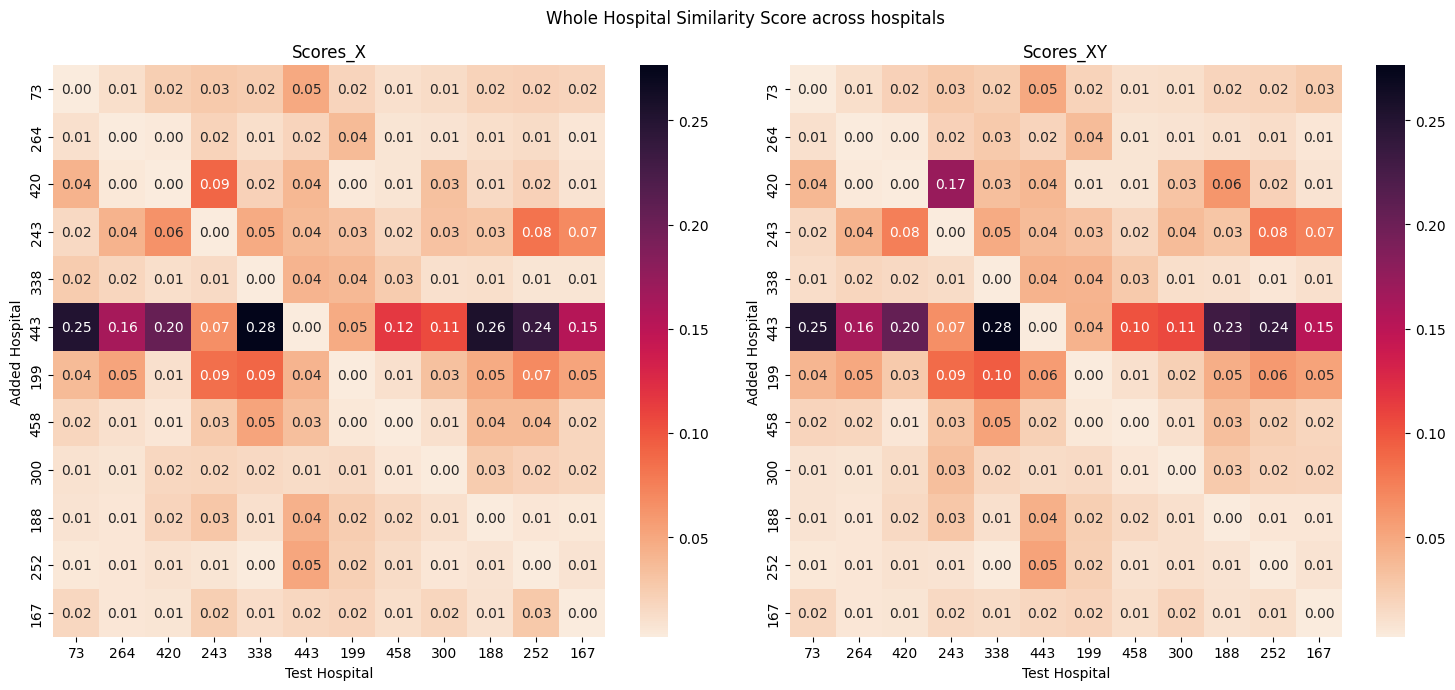

In [46]:
results_x, results_xy = compute_kl_subgroup_score(max_train_samples=1500)

plot_subgroup_score_heatmaps(results_x, results_xy, "Whole Hospital")

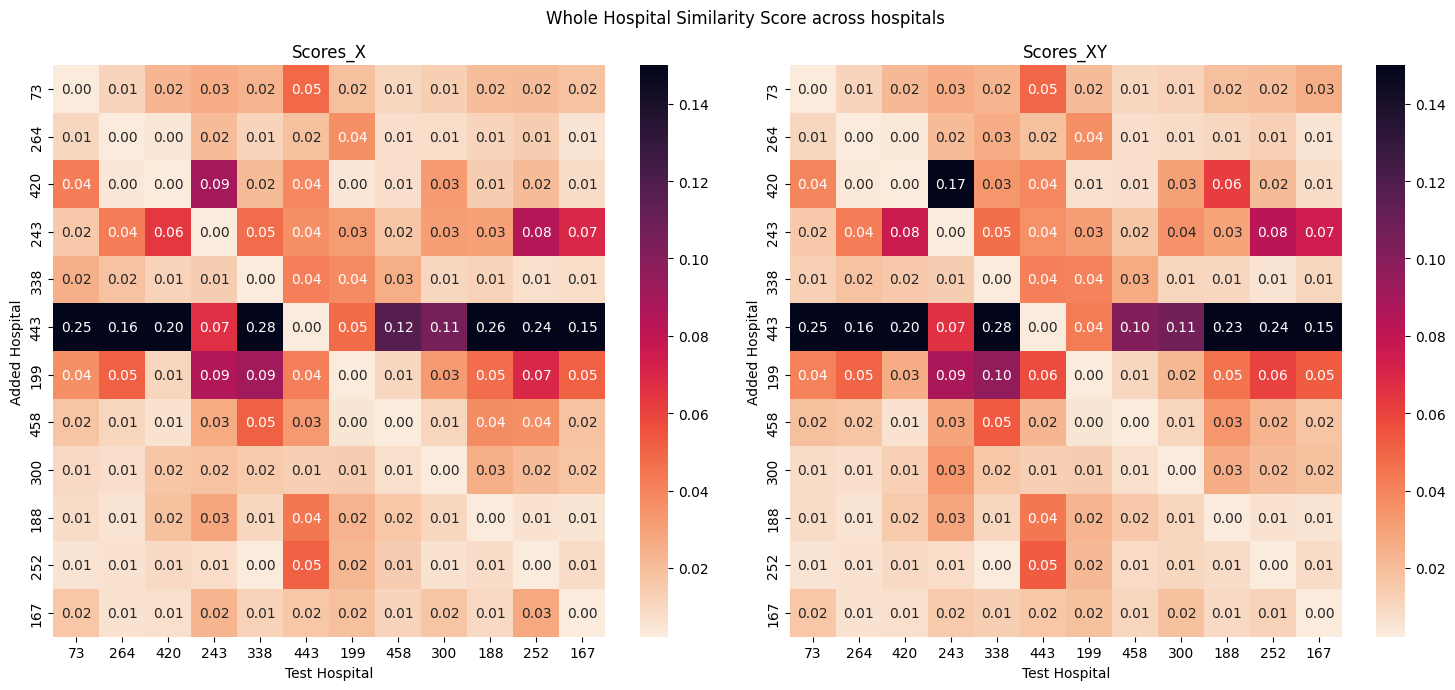

In [48]:
plot_subgroup_score_heatmaps(results_x, results_xy, "Whole Hospital", vmax_x=0.15, vmax_xy=0.15)

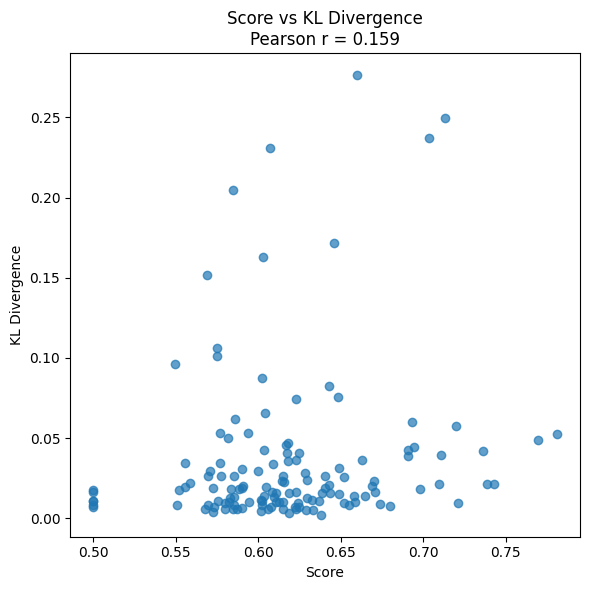

In [50]:
def plot_matrix_correlation(
    mat1,
    mat2,
    label1="Metric 1",
    label2="Metric 2",
    ignore_diagonal=True,
):
    """
    Given two matrices of the same shape, plot a scatter of their entries
    and show the Pearson correlation.

    Parameters
    ----------
    mat1, mat2 : np.ndarray
        Matrices of the same shape (e.g., results_x, results_xy).
    label1, label2 : str
        Axis labels for the two metrics.
    ignore_diagonal : bool
        If True, ignore diagonal elements (i == j).
    """
    assert mat1.shape == mat2.shape, "Matrices must have the same shape"
    n, m = mat1.shape

    # Mask valid entries
    mask = ~np.isnan(mat1) & ~np.isnan(mat2)
    if ignore_diagonal and n == m:
        mask &= ~np.eye(n, dtype=bool)

    x = mat1[mask].ravel()
    y = mat2[mask].ravel()

    if x.size == 0:
        print("No valid points to plot.")
        return

    # Pearson correlation
    r = np.corrcoef(x, y)[0, 1]

    # Scatter plot (let matplotlib choose scales)
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.7)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(f"{label1} vs {label2}\nPearson r = {r:.3f}")
    plt.tight_layout()
    plt.show()


plot_matrix_correlation(other_results_xy_balanced, results_xy, "Score", "KL Divergence")


# visualizations

In [ ]:
model = "LogisticRegression"
metric = "ACC_TEST"
n = 1000

base_avg = np.load(f"../results/base/{model}-n{n}-avg.npz", allow_pickle=True)
add_data_avg = np.load(f"../results/add_data/{model}-n{n}-avg.npz", allow_pickle=True)
add_data_std = np.load(f"../results/add_data/{model}-n{n}-std.npz", allow_pickle=True)
add_subgroup_avg = np.load(f"../results/add_subgroup/{model}-n{n}-avg.npz", allow_pickle=True)
add_subgroup_std = np.load(f"../results/add_subgroup/{model}-n{n}-std.npz", allow_pickle=True)

# dist_shift_avg = np.load(f"../results/dist_shift/{model}-avg.npz", allow_pickle=True) 
dist_shift_avg = add_data_avg

auc_metrics = [file for file in add_data_avg.files if re.compile(rf'.*{metric}.*').match(file)]

base_columns = ['hosp_id', 'count', metric]

In [ ]:
black_score_x = np.load(f"../results/distances/black-score-x.npy")
black_score_xy = np.load(f"../results/distances/black-score-xy.npy")

white_score_x = np.load(f"../results/distances/white-score-x.npy")
white_score_xy = np.load(f"../results/distances/white-score-xy.npy")

other_score_x = np.load(f"../results/distances/other-score-x.npy")
other_score_xy = np.load(f"../results/distances/other-score-xy.npy")

kl = np.load("../results/distances/KL.npz")["KL_xy"][0]
kl_white = np.load("../results/distances/KL-xy-white.npz")['kl_scores']
kl_black = np.load("../results/distances/KL-xy-black.npz")['kl_scores']
kl_other = np.load("../results/distances/KL-xy-other.npz")['kl_scores']

In [ ]:
diff = add_data_avg[metric] - list(base_avg[metric].item().values())

# np.fill_diagonal(diff, 0)

In [ ]:
plot_df = pd.DataFrame()

if metric == 'ACC_TEST':
    plot_df[f'{model}-base-{metric}'] = np.repeat(np.diagonal(dist_shift_avg[f'{metric}']).reshape(-1, 1), len(hospital_ids), axis=1).T.flatten()
elif metric == 'AUC_TEST':
    plot_df[f'{model}-base-{metric}'] = np.repeat(np.diagonal(dist_shift_avg[f'AUC']).reshape(-1, 1), len(hospital_ids), axis=1).T.flatten()
plot_df[f'{model}-add_data-{metric}'] = add_data_avg[f'{metric}'].flatten()
plot_df[f'{model}-add_data-{metric}-std'] = add_data_std[f'{metric}'].flatten()
plot_df[f'{model}-add_data-{metric}-diff'] = plot_df[f'{model}-add_data-{metric}'] - plot_df[f'{model}-base-{metric}']

for i in range(1, 4):
    plot_df[f"{model}-base-{map_attribute[f'race{i}']}-{metric}"] = np.repeat(np.diagonal(dist_shift_avg[f'race{i}_{metric}']).reshape(-1, 1), len(hospital_ids), axis=1).T.flatten()
    plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}"] = add_data_avg[f"race{i}_{metric}"].flatten()
    plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}-std"] = add_data_std[f"race{i}_{metric}"].flatten()
    plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}"] = add_subgroup_avg[map_attribute[f'race{i}']].item()[f"race{i}_{metric}"].flatten()
    plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}-std"] = add_subgroup_std[map_attribute[f'race{i}']].item()[f"race{i}_{metric}"].flatten()
    
    plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}-diff"] = plot_df[f"{model}-add_data-{map_attribute[f'race{i}']}-{metric}"] - plot_df[f"{model}-base-{map_attribute[f'race{i}']}-{metric}"]
    plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}-diff"] = plot_df[f"{model}-add_subgroup-{map_attribute[f'race{i}']}-{metric}"] - plot_df[f"{model}-base-{map_attribute[f'race{i}']}-{metric}"]
    
plot_df['black-score-x'] = black_score_x.flatten()
plot_df['black-score-xy'] = black_score_xy.flatten()

plot_df['black-score-x-balanced'] = black_results_x_balanced.flatten()
plot_df['black-score-xy-balanced'] = black_results_xy_balanced.flatten()

plot_df['other-score-x'] = other_score_x.flatten()
plot_df['other-score-xy'] = other_score_xy.flatten()

plot_df['other-score-x-balanced'] = other_results_x_balanced.flatten()
plot_df['other-score-xy-balanced'] = other_results_xy_balanced.flatten()

plot_df['white-score-x'] = white_score_x.flatten()
plot_df['white-score-xy'] = white_score_xy.flatten()

plot_df['white-score-x-balanced'] = white_results_x_balanced.flatten()
plot_df['white-score-xy-balanced'] = white_results_xy_balanced.flatten()

plot_df['kl'] = kl.flatten()
plot_df['white-kl'] = kl.flatten()
plot_df['black-kl'] = kl_black.flatten()
plot_df['other-kl'] = kl_other.flatten()

plot_df['train_hospital'] = np.repeat(hospital_ids, repeats=len(hospital_ids))
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(np.array(hospital_ids).reshape(-1, 1), repeats=len(hospital_ids), axis=1).T.flatten()

In [ ]:
def plot_scatterplot_by_train_hosp(plot_df, x, y):
    plot_df = plot_df[(plot_df[x] != 0) & (plot_df[y] != 0)]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatterplot with hue and style for 'train_hospital'
    sns.scatterplot(data=plot_df, x=x, y=y, 
                    hue='train_hospital', style='train_hospital', s=150, ax=ax)

    # Add a regression line without scatter points
    sns.regplot(x=x, y=y, data=plot_df, 
                scatter=False, color='silver', ax=ax)

    # Compute correlation coefficient and p-value
    corr_coef, p_value = pearsonr(plot_df[x], plot_df[y])

    # Add correlation coefficient and p-value text on the plot
    text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')

    # Customize legend position and title
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)
    leg.set_title('Train\nHospital', prop={'size': 16})

    # Set axis labels and title
    ax.set_xlabel(f'{x}')
    ax.set_ylabel(f'{y}')
    ax.set_title(f'{x} vs. {y}')

    # Save the plot
#     plt.savefig(f'figures/dataadd_ood_auc_{model}.pdf', bbox_inches='tight')
    plt.show()

    # Print correlation details
#     print(f'{subgroup} Similarity Score-X vs. Data-Addition Correlation')

def plot_scatterplot_by_test_hosp(plot_df, x, y, log_scale=False):
    plot_df = plot_df[(plot_df[x] != 0) & (plot_df[y] != 0)]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define 12 unique colors and markers
    unique_values = plot_df['test_hospital'].nunique()
    palette = sns.color_palette("husl", unique_values)  # Creates 12 unique colors
    markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']  # 12 unique markers
    
    correlation_dict = {}
    for test_hospital, group in plot_df.groupby('test_hospital'):
        if len(group) > 1:  # Ensure there are enough data points to compute correlation
            corr_coef, p_value = pearsonr(group[x], group[y])
            correlation_dict[test_hospital] = (corr_coef, p_value)
        else:
            correlation_dict[test_hospital] = (np.nan, np.nan)  # Not enough points for correlation

    # Scatterplot with hue and style for 'test_hospital'
    sns.scatterplot(data=plot_df, x=x, y=y, 
                    hue='test_hospital', style='test_hospital', 
                    palette=palette, markers=markers, s=150, ax=ax)

    # Add a regression line without scatter points
    sns.regplot(x=x, y=y, data=plot_df, 
                scatter=False, color='silver', ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        # Parse test_hospital label and add correlation coefficient
        try:
            test_hospital = int(label)  # Convert label to integer to match test hospital IDs
            corr_coef, p_value = correlation_dict.get(test_hospital, (np.nan, np.nan))
            new_label = f'{label} (r={corr_coef:.2f}, p={p_value:.2f})'
        except ValueError:
            new_label = label  # For labels that aren’t test hospitals
        new_labels.append(new_label)

    info = y.split('-')
    model, exp, subg, metric = info[0], info[1], info[2], info[3]
    # Compute correlation coefficient and p-value
    corr_coef, p_value = pearsonr(plot_df[x], plot_df[y])
    
    infox = x.split('-')

    # Add correlation coefficient and p-value text on the plot
    text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2f}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')

    # Customize legend position and title
    ax.legend(handles=handles, labels=new_labels, loc='center left', 
              bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14).set_title('Test Hospital', prop={'size': 14})

    # Set axis labels and title
    ax.set_xlabel(f'{infox[0].capitalize()} KL Score', fontsize=14)
    if log_scale:
        ax.set_xscale('log')
    
    if y.split('-')[-1] == 'diff':
        ax.set_ylabel(f'Change in {subg.capitalize()} {format_metric[metric]}', fontsize=14)
    else:
        ax.set_ylabel(f'{subg.capitalize()} {format_metric[metric]}', fontsize=14)
    # ax.set_title(f'{x} vs. {y}')

    plt.show()

In [ ]:
plot_scatterplot_by_test_hosp(plot_df, x="black-score-xy-balanced", y=f"{model}-add_subgroup-black-{metric}-diff")

In [ ]:
def plot_scatterplot_by_test_hosp(plot_df, x, y, log_scale=False, apply_correction=True):
    plot_df = plot_df[(plot_df[x] != 0) & (plot_df[y] != 0)]
    
    fig, ax = plt.subplots(figsize=(9, 8))  # Increased height to accommodate legend below

    # Define 12 unique colors and markers
    unique_values = plot_df['test_hospital'].nunique()
    palette = sns.color_palette("husl", unique_values)
    markers = ['o', '<', 'D', '^', 'v', 's', '>', 'p', '*', 'X', 'P', 'h']
    
    correlation_dict = {}
    p_values_list = []  # Collect all p-values for correction
    
    for test_hospital, group in plot_df.groupby('test_hospital'):
        if len(group) > 1:
            corr_coef, p_value = pearsonr(group[x], group[y])
            correlation_dict[test_hospital] = (corr_coef, p_value)
            p_values_list.append(p_value)
        else:
            correlation_dict[test_hospital] = (np.nan, np.nan)
    
    # Apply Bonferroni correction
    n_tests = len(p_values_list)
    if apply_correction and n_tests > 0:
        corrected_alpha = 0.05 / n_tests
        correction_note = f' (Bonferroni corrected: α={corrected_alpha:.4f})'
    else:
        correction_note = ''

    # Scatterplot
    sns.scatterplot(data=plot_df, x=x, y=y, 
                    hue='test_hospital', style='test_hospital', 
                    palette=palette, markers=markers, s=150, ax=ax)

    # Add regression line
    sns.regplot(x=x, y=y, data=plot_df, 
                scatter=False, color='silver', ax=ax)
    
    # Update legend with corrected significance indicators
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        try:
            test_hospital = int(label)
            corr_coef, p_value = correlation_dict.get(test_hospital, (np.nan, np.nan))
            
            # Add significance indicator based on corrected threshold
            if apply_correction and not np.isnan(p_value):
                sig_indicator = '*' if p_value < corrected_alpha else ''
                new_label = f'{label} (r={corr_coef:.2f}, p={p_value:.3f} {sig_indicator})'
            else:
                new_label = f'{label} (r={corr_coef:.2f}, p={p_value:.3f})'
        except ValueError:
            new_label = label
        new_labels.append(new_label)

    info = y.split('-')
    model, exp, subg, metric = info[0], info[1], info[2], info[3]
    
    # Overall correlation
    corr_coef, p_value = pearsonr(plot_df[x], plot_df[y])
    
    infox = x.split('-')

    # Add correlation text with correction note
    text_str = f'Overall Correlation: {corr_coef:.2f}\np-value: {p_value:.3f}{correction_note}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Place legend below plot in 3 columns of 4
    ax.legend(handles=handles, labels=new_labels, 
              loc='upper center', bbox_to_anchor=(0.5, -0.15),
              ncol=3, frameon=False, fontsize=12,
              title='Test Hospital', title_fontsize=14)

    ax.set_xlabel(f'{infox[0].capitalize()} Score', fontsize=14)
    if log_scale:
        ax.set_xscale('log')
    
    if y.split('-')[-1] == 'diff':
        ax.set_ylabel(f'Change in {subg.capitalize()} {format_metric[metric]}', fontsize=14)
    else:
        ax.set_ylabel(f'{subg.capitalize()} {format_metric[metric]}', fontsize=14)

    plt.tight_layout()
    plt.show()
    
    # Return summary for paper
    return {
        'n_tests': n_tests,
        'corrected_alpha': corrected_alpha if apply_correction else 0.05,
        'significant_count': sum(p < corrected_alpha for p in p_values_list) if apply_correction else sum(p < corrected_alpha for p in p_values_list)
    }

In [ ]:
plot_scatterplot_by_test_hosp(plot_df, x="white-score-xy", y=f"{model}-add_subgroup-white-{metric}-diff")

In [ ]:
def correlation_with_mixed_effects(plot_df, x, y):
    """
    Mixed effects model accounting for hospital clustering.
    
    Parameters:
    -----------
    x : str
        Column name for predictor variable
    y : str
        Column name for outcome variable
    plot_df : DataFrame
        Data containing x, y, and 'test_hospital' columns
    """
    # Create clean column names for formula (replace special chars)
    df_temp = plot_df[[x, y, 'test_hospital']].copy()
    df_temp.columns = ['predictor', 'outcome', 'test_hospital']
    
    # Mixed effects model: outcome ~ predictor + (1|test_hospital)
    model = MixedLM.from_formula('outcome ~ predictor', 
                                  data=df_temp, 
                                  groups=df_temp['test_hospital'])
    result = model.fit()
    
    # Extract coefficient for predictor and its p-value
    coef = result.params['predictor']
    p_value = result.pvalues['predictor']
    
    return coef, p_value, result

In [ ]:
plot_df

In [ ]:
correlation_with_mixed_effects(plot_df, x="white-score-xy", y=f"{model}-add_subgroup-white-{metric}")

In [ ]:
plot_scatterplot_by_test_hosp(plot_df, x="white-score-xy-balanced", y=f"{model}-add_subgroup-white-{metric}-diff")

In [ ]:
plot_scatterplot_by_test_hosp(plot_df, x="white-score-xy-balanced", y=f"{model}-add_subgroup-white-{metric}")

In [ ]:
black_hosp_thresh_str = ["73", "188", "243", "300", "443", "458"]
black_hosp_thresh = [73, 188, 243, 300, 443, 458]
plot_df_black = plot_df[(plot_df['train_hospital'].isin(black_hosp_thresh_str))]

plot_scatterplot_by_test_hosp(plot_df_black, x="black-score-xy-balanced", y=f"{model}-add_subgroup-black-{metric}-diff")

In [ ]:
other_hosp_thresh_str = ["73", "167", "338", "420", "458"]
other_hosp_thresh = [73, 167, 338, 420, 458]
plot_df_other = plot_df[(plot_df['test_hospital'].isin(other_hosp_thresh))]

plot_scatterplot_by_test_hosp(plot_df_other, x="other-score-xy-balanced", y=f'{model}-add_subgroup-other-{metric}')